# Capstone project: The battle of neighborhoods

## 1. Install packages

In [1]:
!conda install -c conda-forge beautifulsoup4 --yes
!conda install -c conda-forge geocoder --yes
!conda install -c conda-forge geopy --yes
!conda install -c conda-forge folium=0.5.0 --yes

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.11

Please update conda by running

    $ conda update -n base -c defaults conda



## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs: 
    - beautifulsoup4


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    soupsieve-1.9.3            |           py36_0          57 KB  conda-forge
    beautifulsoup4-4.8.0       |           py36_0         144 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         201 KB

The following NEW packages will be INSTALLED:

    soupsieve:      1.9.3-py36_0 conda-forge

The following packages will be UPDATED:

    beautifulsoup4: 4.6.3-py37_0             --> 4.8.0-py36_0 conda-forge


soupsieve-1.9.3     

**Import packages**

In [2]:
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

from bs4 import BeautifulSoup
import requests

import folium # plotting library

print('Packages are imported.')

Packages are imported.


**Setup folium account**

In [3]:
CLIENT_ID = 'FDFJT0DMNEJYZ2JY5I0WQU4DUYRJB52N2AIB2LI3ISWYNDCF' # your Foursquare ID
CLIENT_SECRET = 'B4REIBHMWRP3HEX5ZDC1ZBCAGH2WTZ4D4AOVB053NJKY45RD' # your Foursquare Secret
VERSION = '20180605'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: FDFJT0DMNEJYZ2JY5I0WQU4DUYRJB52N2AIB2LI3ISWYNDCF
CLIENT_SECRET:B4REIBHMWRP3HEX5ZDC1ZBCAGH2WTZ4D4AOVB053NJKY45RD


## 2. Introduction
In this report, we try to answer the question of:
Can we figure out areas in Ho Chi Minh city where a gym/fitness centre can be launched?
Our solution to the above business question mainly depends on data science methodology and cluster analysis of machine learning technique.

**Collecting neighborhood data**

In [5]:
#link = 'http://www.pso.hochiminhcity.gov.vn/web/guest/danhmucthongke-danhmucphuongxa'
link = 'https://en.wikipedia.org/wiki/Category:Districts_of_Ho_Chi_Minh_City'
crawled_page = requests.get(link)
soup = BeautifulSoup(crawled_page.text, 'html.parser')
print('Page\'s title is: ', soup.title.string)

Page's title is:  Category:Districts of Ho Chi Minh City - Wikipedia


**Analyzing html content**

In [46]:
div_data = soup.find_all("div", attrs={"class" : "mw-category-group"})
div_text = ''.join(map(str, div_data))
soup2 = BeautifulSoup(div_text, 'html.parser')
ul_data = soup2.find_all('ul')
ul_text = ''.join(map(str, ul_data))
soup3 = BeautifulSoup(ul_text, 'html.parser')
neighborhoods = [i.text for i in soup3.find_all('li')] 
del neighborhoods[0]
print('Total neighborhoods: ', len(neighborhoods))   
neighborhoods[:3]

Total neighborhoods:  24


['Bình Chánh District', 'Bình Tân District', 'Bình Thạnh District']

**Get coordinates of neighborhoods**

In [52]:
address = ', Ho Chi Minh, Viet Nam'
my_agent ='vn_sg_coursera_capstone'
geolocator = Nominatim(user_agent=my_agent)
lats = []
longis = []
for neigh in neighborhoods:
    neigh_add = neigh + address
    location = geolocator.geocode(neigh_add)
    lats.append(float(location.latitude))
    longis.append(float(location.longitude))

**Save neighborhood data to csv**

In [55]:
cols = ['Neighborhood', 'Latitude', 'Longitude']
df = pd.DataFrame(list(zip(neighborhoods, lats, longis)), columns = cols)
print(df.shape)
df.head()

(24, 3)


,Neighborhood,Latitude,Longitude
0,Bình Chánh District,10.690115,106.582677
1,Bình Tân District,10.749809,106.605664
2,Bình Thạnh District,10.804659,106.707848
3,Cần Giờ District,10.398254,106.921951
4,Củ Chi District,10.975609,106.499711


In [56]:
df.to_csv('hcm_geo.csv', encoding='utf-8', index=False)
print('Finish exporting to csv')

Finish exporting to csv


## 3. Exploring the neighborhoods in Ho Chi Minh city

In [24]:
df = pd.read_csv('hcm_geo.csv')
df.head()

,Neighborhood,Latitude,Longitude
0,Bình Chánh District,10.690115,106.582677
1,Bình Tân District,10.749809,106.605664
2,Bình Thạnh District,10.804659,106.707848
3,Cần Giờ District,10.398254,106.921951
4,Củ Chi District,10.975609,106.499711


In [25]:
#get coordinates of Ho Chi Minh city
address = 'Ho Chi Minh, Viet Nam'
my_agent ='vn_sg_coursera_capstone'
geolocator = Nominatim(user_agent=my_agent)
location = geolocator.geocode(address)
hcm_lat = location.latitude
hcm_longi = location.longitude

# create map of Manhattan using latitude and longitude values
map_hcm = folium.Map(location=[hcm_lat, hcm_longi], zoom_start=11)

# add markers to map
for lat, lng, label in zip(df['Latitude'], df['Longitude'], df['Neighborhood']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_hcm)  
    
map_hcm

**Get top 100 venues of every neighborhood within a radius of 1 km**

In [26]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 1000 # define radius

In [27]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes): 
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [28]:
hcm_venues = getNearbyVenues(names=df['Neighborhood'],
                                   latitudes=df['Latitude'],
                                   longitudes=df['Longitude']
                                  )

In [30]:
print(hcm_venues.shape)
hcm_venues.head()

(661, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bình Chánh District,10.690115,106.582677,Van Thinh Rest Stop,10.687641,106.584976,Vietnamese Restaurant
1,Bình Chánh District,10.690115,106.582677,Bánh Bao Phong Lan,10.692805,106.577061,Bakery
2,Bình Chánh District,10.690115,106.582677,Binh Dien Quan Restaurant,10.695333,106.587668,Vietnamese Restaurant
3,Bình Chánh District,10.690115,106.582677,Kedai Sarah,10.688974,106.574965,Women's Store
4,Bình Tân District,10.749809,106.605664,Coffee Bui Van Ngo,10.751648,106.612534,Café


In [31]:
hcm_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bình Chánh District,4,4,4,4,4,4
Bình Thạnh District,29,29,29,29,29,29
Bình Tân District,4,4,4,4,4,4
Cần Giờ District,1,1,1,1,1,1
Củ Chi District,8,8,8,8,8,8
"District 1, Ho Chi Minh City",100,100,100,100,100,100
"District 10, Ho Chi Minh City",71,71,71,71,71,71
"District 11, Ho Chi Minh City",9,9,9,9,9,9
"District 12, Ho Chi Minh City",8,8,8,8,8,8


In [32]:
print('There are {} uniques categories.'.format(len(hcm_venues['Venue Category'].unique())))

There are 116 uniques categories.


**Analyze each neighborhood**

In [33]:
# one hot encoding
hcm_onehot = pd.get_dummies(hcm_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
hcm_onehot['Neighborhood'] = hcm_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [hcm_onehot.columns[-1]] + list(hcm_onehot.columns[:-1])
hcm_onehot = hcm_onehot[fixed_columns]
print(hcm_onehot.shape)
hcm_onehot.head()

(661, 117)


,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,...,Track Stadium,Trail,Travel Agency,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Whisky Bar,Women's Store,Yoga Studio
0,Bình Chánh District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,Bình Chánh District,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,Bình Chánh District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,Bình Chánh District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Bình Tân District,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
hcm_grouped = hcm_onehot.groupby('Neighborhood').mean().reset_index()
print(hcm_grouped.shape)
hcm_grouped.head()

(23, 117)


,Neighborhood,American Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,BBQ Joint,Bagel Shop,Bakery,Bar,...,Track Stadium,Trail,Travel Agency,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Water Park,Whisky Bar,Women's Store,Yoga Studio
0,Bình Chánh District,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.250000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.500000,0.0,0.0,0.25,0.0
1,Bình Thạnh District,0.0,0.034483,0.0,0.068966,0.0,0.0,0.0,0.034483,0.0,...,0.0,0.0,0.034483,0.0,0.0,0.172414,0.0,0.0,0.00,0.0
2,Bình Tân District,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
3,Cần Giờ District,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0
4,Củ Chi District,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.00,0.0


**Get top 10 venues**

In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [36]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
hcm_venues_sorted = pd.DataFrame(columns=columns)
hcm_venues_sorted['Neighborhood'] = hcm_grouped['Neighborhood']

for ind in np.arange(hcm_grouped.shape[0]):
    hcm_venues_sorted.iloc[ind, 1:] = return_most_common_venues(hcm_grouped.iloc[ind, :], num_top_venues)
print(hcm_venues_sorted.shape)
hcm_venues_sorted.head()

(23, 11)


,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bình Chánh District,Vietnamese Restaurant,Women's Store,Bakery,Fried Chicken Joint,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store,Fast Food Restaurant
1,Bình Thạnh District,Café,Vietnamese Restaurant,Asian Restaurant,Coffee Shop,Seafood Restaurant,Steakhouse,Bakery,Soup Place,French Restaurant,Fried Chicken Joint
2,Bình Tân District,Italian Restaurant,Shopping Mall,Chinese Restaurant,Café,Yoga Studio,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant
3,Cần Giờ District,Café,Yoga Studio,French Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Flea Market
4,Củ Chi District,Café,Coffee Shop,Seafood Restaurant,Convention Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store


## 4. Clustering the neighborhoods in Ho Chi Minh city

**Elbow analysis**

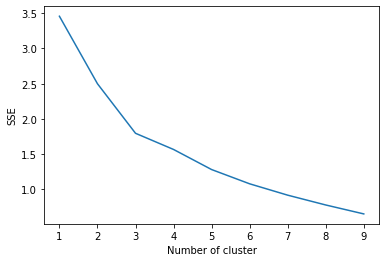

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

sse = {}
hcm_grouped_clustering = hcm_grouped.drop('Neighborhood', 1)

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(hcm_grouped_clustering)
    hcm_grouped_clustering["clusters"] = kmeans.labels_
    #print(data["clusters"])
    sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.ylabel("SSE")
plt.show()

**Build k-means model with k = 3**

In [38]:
# set number of clusters
kclusters = 3

hcm_grouped_clustering = hcm_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(hcm_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 0], dtype=int32)

In [39]:
#hcm_venues_sorted.drop(['Cluster Labels'], axis = 1, inplace=True)

In [40]:
# add clustering labels
hcm_venues_sorted.insert(1, 'Cluster Labels', kmeans.labels_)

hcm_merged = df

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
hcm_merged = hcm_merged.join(hcm_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
hcm_merged 

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bình Chánh District,10.690115,106.582677,0.0,Vietnamese Restaurant,Women's Store,Bakery,Fried Chicken Joint,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store,Fast Food Restaurant
1,Bình Tân District,10.749809,106.605664,0.0,Italian Restaurant,Shopping Mall,Chinese Restaurant,Café,Yoga Studio,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant
2,Bình Thạnh District,10.804659,106.707848,0.0,Café,Vietnamese Restaurant,Asian Restaurant,Coffee Shop,Seafood Restaurant,Steakhouse,Bakery,Soup Place,French Restaurant,Fried Chicken Joint
3,Cần Giờ District,10.398254,106.921951,1.0,Café,Yoga Studio,French Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Flea Market
4,Củ Chi District,10.975609,106.499711,1.0,Café,Coffee Shop,Seafood Restaurant,Convention Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store
5,"District 1, Ho Chi Minh City",10.774540,106.699184,0.0,Vietnamese Restaurant,Hotel,Café,Coffee Shop,Burger Joint,Massage Studio,Clothing Store,Bar,Italian Restaurant,Nightclub
6,"District 2, Ho Chi Minh City",10.791116,106.736729,0.0,Café,Vietnamese Restaurant,Restaurant,BBQ Joint,Breakfast Spot,Bookstore,Dumpling Restaurant,Diner,Food Truck,Fast Food Restaurant
7,"District 3, Ho Chi Minh City",10.783529,106.687098,0.0,Vietnamese Restaurant,Café,Asian Restaurant,Coffee Shop,French Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Yoga Studio,Sushi Restaurant,Noodle House
8,"District 4, Ho Chi Minh City",10.759243,106.704890,0.0,Seafood Restaurant,BBQ Joint,Snack Place,Vietnamese Restaurant,Café,Japanese Restaurant,Boat or Ferry,Diner,Food,Asian Restaurant
9,"District 5, Ho Chi Minh City",10.756129,106.670375,0.0,Vietnamese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Coffee Shop,Noodle House,Café,Asian Restaurant,Dessert Shop,Seafood Restaurant,Vegetarian / Vegan Restaurant


In [41]:
hcm_cleaned = hcm_merged.dropna()
hcm_cleaned = hcm_cleaned.astype({"Cluster Labels": int})
hcm_cleaned["Cluster Labels"] = hcm_cleaned["Cluster Labels"] + 1

In [42]:
hcm_cleaned.head()

,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bình Chánh District,10.690115,106.582677,1,Vietnamese Restaurant,Women's Store,Bakery,Fried Chicken Joint,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store,Fast Food Restaurant
1,Bình Tân District,10.749809,106.605664,1,Italian Restaurant,Shopping Mall,Chinese Restaurant,Café,Yoga Studio,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant
2,Bình Thạnh District,10.804659,106.707848,1,Café,Vietnamese Restaurant,Asian Restaurant,Coffee Shop,Seafood Restaurant,Steakhouse,Bakery,Soup Place,French Restaurant,Fried Chicken Joint
3,Cần Giờ District,10.398254,106.921951,2,Café,Yoga Studio,French Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Flea Market
4,Củ Chi District,10.975609,106.499711,2,Café,Coffee Shop,Seafood Restaurant,Convention Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store


In [43]:
# create map
map_clusters = folium.Map(location=[hcm_lat, hcm_longi], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(hcm_cleaned['Latitude'], hcm_cleaned['Longitude'], 
                                  hcm_cleaned['Neighborhood'], 
                                  hcm_cleaned['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## 5. Examine clusters

In [44]:
hcm_cleaned.loc[hcm_cleaned['Cluster Labels'] == 1, 
                hcm_cleaned.columns[[0] + list(range(4, hcm_cleaned.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bình Chánh District,Vietnamese Restaurant,Women's Store,Bakery,Fried Chicken Joint,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store,Fast Food Restaurant
1,Bình Tân District,Italian Restaurant,Shopping Mall,Chinese Restaurant,Café,Yoga Studio,Food Court,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant
2,Bình Thạnh District,Café,Vietnamese Restaurant,Asian Restaurant,Coffee Shop,Seafood Restaurant,Steakhouse,Bakery,Soup Place,French Restaurant,Fried Chicken Joint
5,"District 1, Ho Chi Minh City",Vietnamese Restaurant,Hotel,Café,Coffee Shop,Burger Joint,Massage Studio,Clothing Store,Bar,Italian Restaurant,Nightclub
6,"District 2, Ho Chi Minh City",Café,Vietnamese Restaurant,Restaurant,BBQ Joint,Breakfast Spot,Bookstore,Dumpling Restaurant,Diner,Food Truck,Fast Food Restaurant
7,"District 3, Ho Chi Minh City",Vietnamese Restaurant,Café,Asian Restaurant,Coffee Shop,French Restaurant,Seafood Restaurant,Vegetarian / Vegan Restaurant,Yoga Studio,Sushi Restaurant,Noodle House
8,"District 4, Ho Chi Minh City",Seafood Restaurant,BBQ Joint,Snack Place,Vietnamese Restaurant,Café,Japanese Restaurant,Boat or Ferry,Diner,Food,Asian Restaurant
9,"District 5, Ho Chi Minh City",Vietnamese Restaurant,Chinese Restaurant,Dim Sum Restaurant,Coffee Shop,Noodle House,Café,Asian Restaurant,Dessert Shop,Seafood Restaurant,Vegetarian / Vegan Restaurant
10,"District 6, Ho Chi Minh City",Supermarket,Café,Flea Market,Movie Theater,Pizza Place,Vietnamese Restaurant,Asian Restaurant,Department Store,Bagel Shop,Fast Food Restaurant
11,"District 7, Ho Chi Minh City",Vietnamese Restaurant,Café,Supermarket,Flea Market,Sushi Restaurant,Multiplex,Gym / Fitness Center,Residential Building (Apartment / Condo),Shopping Mall,Scandinavian Restaurant


In [45]:
hcm_cleaned.loc[hcm_cleaned['Cluster Labels'] == 2, 
                hcm_cleaned.columns[[0] + list(range(4, hcm_cleaned.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Cần Giờ District,Café,Yoga Studio,French Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Flea Market
4,Củ Chi District,Café,Coffee Shop,Seafood Restaurant,Convention Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store


In [46]:
hcm_cleaned.loc[hcm_cleaned['Cluster Labels'] == 3, 
                hcm_cleaned.columns[[0] + list(range(4, hcm_cleaned.shape[1]))]]

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
19,Nhà Bè District,Coffee Shop,Yoga Studio,French Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Dumpling Restaurant,Electronics Store,Fast Food Restaurant,Flea Market


## 6. Discussion
As the observation results in the previous section, gym/fitness centre have not been developed as many as other kinds of business like restaurants or coffee shops in HCM city. Hence there are big opportunities for opening a gym/fitness centre in this city in general. In particular, we can select the areas of group 2 and/or group 3 to launch our centre. Because gym/fitness does not appear in the top 10 venue categories of these two groups. Eventually, we can think of launching our centre in many points of group 1, because the number of this kind of centre is small in comparison with other kinds of business.

## 7. Conclusion
In this study, we have defined the business problem, figured out data requirements, collected and merged data from multiple sources, transformed data, visualized data and analyzed clustered results. The findings of this study can be briefly reported as follows. 

    1. There is big opportunity for opening gym/fitness centre in HCM city because this kind of business has not been developed;
    2.  The opportunity is high at areas of group 2 \& 3.
    3. In the areas of group 1, there is still lot of opportunities because gym/fitness centres are just minority and low rank in the top 10 venue categories of this group.
